In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.linalg import norm
from tqdm import tqdm

## 1. importing data

### load data

In [2]:
rating_data = pd.read_csv('data/rating.csv')
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### check data shapes & types

In [3]:
rating_data.shape

(7813737, 3)

In [4]:
rating_data.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object

In [5]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


### handle duplicates data

In [6]:
# check duplicate data
rating_data.duplicated(subset=['user_id', 'anime_id']).sum()

7

In [7]:
rating_data[rating_data.duplicated(subset=['user_id', 'anime_id'])]

,user_id,anime_id,rating
4499286,42653,1575,6
4499288,42653,2001,10
4499307,42653,11757,5
4499316,42653,16498,8
4499320,42653,20507,9
4499325,42653,22319,6
4499326,42653,23283,9


In [8]:
# check more detail
rating_data[(rating_data.user_id == 42653) & (rating_data.anime_id == 1575)]

,user_id,anime_id,rating
4499243,42653,1575,8
4499286,42653,1575,6


In [9]:
# drop duplicate, retrieve last rating 
rating_data.drop_duplicates(subset=['user_id', 'anime_id'], keep='last', inplace=True)
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [10]:
rating_data.shape

(7813730, 3)

In [11]:
# recheck duplicate data
rating_data.duplicated(subset=['user_id', 'anime_id']).sum()

0

### create load function

In [12]:
def load_rating_data(rating_path):
    '''
    function to load data & remove from duplicates

    parameters
    ----------
    rating_path : str
        path of rating data (.csv)

    returns
    -------
    rating_data : pandas dataframe
        rating data
    '''
    
    # load data
    rating_data = pd.read_csv(rating_path)
    print('original data shape:', rating_data.shape)
    
    # temp: remove implicit data (rating = -1)
    rating_data = rating_data[rating_data.rating != -1]

    # drop duplicate, retrieve last rating 
    rating_data.drop_duplicates(subset=['user_id', 'anime_id'], keep='last', inplace=True)
    print('final data shape:', rating_data.shape)

    return rating_data

In [13]:
rating_data = load_rating_data('data/rating.csv')

original data shape: (7813737, 3)
final data shape: (6337234, 3)


In [14]:
rating_data.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


## 2. modelling: funk svd

### mapping `user_id` and `anime_id`

In [15]:
# mapping user_id into ordered id
user_to_id = {user: id for id, user in enumerate(rating_data.user_id.unique())}

# mapping ordered id back into user_id
id_to_user = {id: user for id, user in enumerate(rating_data.user_id.unique())}

In [16]:
user_to_id

{1: 0,
 2: 1,
 3: 2,
 5: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9,
 14: 10,
 15: 11,
 16: 12,
 17: 13,
 18: 14,
 19: 15,
 20: 16,
 21: 17,
 22: 18,
 23: 19,
 24: 20,
 25: 21,
 26: 22,
 27: 23,
 28: 24,
 29: 25,
 30: 26,
 31: 27,
 32: 28,
 33: 29,
 34: 30,
 35: 31,
 36: 32,
 37: 33,
 38: 34,
 39: 35,
 40: 36,
 41: 37,
 42: 38,
 43: 39,
 44: 40,
 45: 41,
 46: 42,
 47: 43,
 48: 44,
 50: 45,
 51: 46,
 52: 47,
 53: 48,
 55: 49,
 56: 50,
 57: 51,
 58: 52,
 59: 53,
 60: 54,
 61: 55,
 62: 56,
 63: 57,
 64: 58,
 65: 59,
 66: 60,
 67: 61,
 68: 62,
 69: 63,
 70: 64,
 71: 65,
 72: 66,
 73: 67,
 74: 68,
 75: 69,
 76: 70,
 77: 71,
 78: 72,
 79: 73,
 80: 74,
 81: 75,
 82: 76,
 83: 77,
 84: 78,
 85: 79,
 86: 80,
 87: 81,
 88: 82,
 90: 83,
 91: 84,
 92: 85,
 93: 86,
 94: 87,
 95: 88,
 96: 89,
 97: 90,
 98: 91,
 99: 92,
 100: 93,
 101: 94,
 102: 95,
 103: 96,
 104: 97,
 105: 98,
 106: 99,
 107: 100,
 108: 101,
 109: 102,
 110: 103,
 111: 104,
 112: 105,
 113: 106,
 114: 107,
 115: 108,
 116: 109,


In [17]:
id_to_user

{0: 1,
 1: 2,
 2: 3,
 3: 5,
 4: 7,
 5: 8,
 6: 9,
 7: 10,
 8: 11,
 9: 12,
 10: 14,
 11: 15,
 12: 16,
 13: 17,
 14: 18,
 15: 19,
 16: 20,
 17: 21,
 18: 22,
 19: 23,
 20: 24,
 21: 25,
 22: 26,
 23: 27,
 24: 28,
 25: 29,
 26: 30,
 27: 31,
 28: 32,
 29: 33,
 30: 34,
 31: 35,
 32: 36,
 33: 37,
 34: 38,
 35: 39,
 36: 40,
 37: 41,
 38: 42,
 39: 43,
 40: 44,
 41: 45,
 42: 46,
 43: 47,
 44: 48,
 45: 50,
 46: 51,
 47: 52,
 48: 53,
 49: 55,
 50: 56,
 51: 57,
 52: 58,
 53: 59,
 54: 60,
 55: 61,
 56: 62,
 57: 63,
 58: 64,
 59: 65,
 60: 66,
 61: 67,
 62: 68,
 63: 69,
 64: 70,
 65: 71,
 66: 72,
 67: 73,
 68: 74,
 69: 75,
 70: 76,
 71: 77,
 72: 78,
 73: 79,
 74: 80,
 75: 81,
 76: 82,
 77: 83,
 78: 84,
 79: 85,
 80: 86,
 81: 87,
 82: 88,
 83: 90,
 84: 91,
 85: 92,
 86: 93,
 87: 94,
 88: 95,
 89: 96,
 90: 97,
 91: 98,
 92: 99,
 93: 100,
 94: 101,
 95: 102,
 96: 103,
 97: 104,
 98: 105,
 99: 106,
 100: 107,
 101: 108,
 102: 109,
 103: 110,
 104: 111,
 105: 112,
 106: 113,
 107: 114,
 108: 115,
 109: 116,


In [18]:
# mapping anime_id into ordered id
anime_to_id = {anime: id for id, anime in enumerate(rating_data.anime_id.unique())}

# mapping ordered id back into anime_id
id_to_anime = {id: anime for id, anime in enumerate(rating_data.anime_id.unique())}

In [19]:
anime_to_id

{8074: 0,
 11617: 1,
 11757: 2,
 15451: 3,
 11771: 4,
 20: 5,
 154: 6,
 170: 7,
 199: 8,
 225: 9,
 341: 10,
 430: 11,
 527: 12,
 552: 13,
 813: 14,
 1119: 15,
 1121: 16,
 1122: 17,
 1132: 18,
 1292: 19,
 1313: 20,
 1526: 21,
 1535: 22,
 1564: 23,
 1689: 24,
 1764: 25,
 1943: 26,
 2201: 27,
 2404: 28,
 2847: 29,
 3588: 30,
 4026: 31,
 5114: 32,
 5231: 33,
 6178: 34,
 6702: 35,
 6880: 36,
 7695: 37,
 9107: 38,
 9135: 39,
 9760: 40,
 9917: 41,
 9919: 42,
 9989: 43,
 10408: 44,
 10507: 45,
 11111: 46,
 11703: 47,
 11737: 48,
 11759: 49,
 12671: 50,
 14075: 51,
 14093: 52,
 14345: 53,
 14513: 54,
 16498: 55,
 16512: 56,
 16782: 57,
 16894: 58,
 16918: 59,
 17265: 60,
 18097: 61,
 18115: 62,
 18393: 63,
 19315: 64,
 19815: 65,
 20021: 66,
 20159: 67,
 20507: 68,
 20583: 69,
 21507: 70,
 21881: 71,
 22199: 72,
 22297: 73,
 22319: 74,
 22547: 75,
 22729: 76,
 23301: 77,
 23321: 78,
 23333: 79,
 23755: 80,
 24415: 81,
 26243: 82,
 27631: 83,
 27899: 84,
 28121: 85,
 28171: 86,
 28223: 87,
 2849

In [20]:
id_to_anime

{0: 8074,
 1: 11617,
 2: 11757,
 3: 15451,
 4: 11771,
 5: 20,
 6: 154,
 7: 170,
 8: 199,
 9: 225,
 10: 341,
 11: 430,
 12: 527,
 13: 552,
 14: 813,
 15: 1119,
 16: 1121,
 17: 1122,
 18: 1132,
 19: 1292,
 20: 1313,
 21: 1526,
 22: 1535,
 23: 1564,
 24: 1689,
 25: 1764,
 26: 1943,
 27: 2201,
 28: 2404,
 29: 2847,
 30: 3588,
 31: 4026,
 32: 5114,
 33: 5231,
 34: 6178,
 35: 6702,
 36: 6880,
 37: 7695,
 38: 9107,
 39: 9135,
 40: 9760,
 41: 9917,
 42: 9919,
 43: 9989,
 44: 10408,
 45: 10507,
 46: 11111,
 47: 11703,
 48: 11737,
 49: 11759,
 50: 12671,
 51: 14075,
 52: 14093,
 53: 14345,
 54: 14513,
 55: 16498,
 56: 16512,
 57: 16782,
 58: 16894,
 59: 16918,
 60: 17265,
 61: 18097,
 62: 18115,
 63: 18393,
 64: 19315,
 65: 19815,
 66: 20021,
 67: 20159,
 68: 20507,
 69: 20583,
 70: 21507,
 71: 21881,
 72: 22199,
 73: 22297,
 74: 22319,
 75: 22547,
 76: 22729,
 77: 23301,
 78: 23321,
 79: 23333,
 80: 23755,
 81: 24415,
 82: 26243,
 83: 27631,
 84: 27899,
 85: 28121,
 86: 28171,
 87: 28223,
 88: 

### converting dataframe to array

In [21]:
# convert dataframe to matrix
rating_matrix = rating_data.to_numpy()

rating_matrix

array([[    1,  8074,    10],
       [    1, 11617,    10],
       [    1, 11757,    10],
       ...,
       [73515, 22145,    10],
       [73516,   790,     9],
       [73516,  8074,     9]])

In [22]:
# check shape
rating_matrix.shape

(6337234, 3)

In [23]:
# compare 1st data in dataframe and array
# dataframe
rating_data.iloc[[0]]

,user_id,anime_id,rating
47,1,8074,10


In [24]:
# array
rating_matrix[0]

array([   1, 8074,   10])

### initialization

In [25]:
# identify number of user and item
n_users = rating_data.user_id.nunique()
n_items = rating_data.anime_id.nunique()

print('n users:', n_users)
print('n items:', n_items)

n users: 69600
n items: 9927


In [26]:
# setting number of n_factor to use
n_factors = 50

In [27]:
# generate user factor (𝑝𝑢) and item factor (𝑞𝑖)
np.random.seed(13)

bu = np.zeros(n_users)
bi = np.zeros(n_items)

pu = np.random.normal(0, 1, (n_users, n_factors))
qi = np.random.normal(0, 1, (n_items, n_factors))

In [28]:
# create copy to compare weight after training
bu_copy = bu.copy()
bi_copy = bi.copy()
pu_copy = pu.copy()
qi_copy = qi.copy()

In [29]:
# check shape
print('bias user shape:', bu.shape)
print('bias item shape:', bi.shape)
print('user factor shape:', pu.shape)
print('item factor shape:', qi.shape)

bias user shape: (69600,)
bias item shape: (9927,)
user factor shape: (69600, 50)
item factor shape: (9927, 50)


In [30]:
bu

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
bi

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
pu

array([[-0.71239066,  0.75376638, -0.04450308, ..., -0.00238903,
        -0.23242587,  0.71097479],
       [ 0.45315861, -0.33267578, -0.38445769, ..., -0.65105648,
        -1.12050687, -0.34660679],
       [-0.91134478, -0.74613525, -0.77096853, ..., -0.94663646,
         0.35136153,  0.78857048],
       ...,
       [-0.33603791, -0.74728279,  1.38935527, ..., -0.5678602 ,
        -0.11420583, -0.26149663],
       [-1.44285174, -0.18738535,  2.24558266, ...,  0.15731241,
         0.96782391, -1.03843113],
       [-1.15269659, -0.16148093, -1.44723112, ..., -0.2309036 ,
         0.33875281, -0.56059431]])

In [33]:
qi

array([[ 0.14740567,  0.13445991, -0.31477049, ..., -1.84035692,
         0.3391904 , -0.41124991],
       [ 1.45235828,  0.77569154, -0.68882631, ...,  1.41511634,
         0.14353454, -1.70917285],
       [-0.42064983,  1.26138376,  0.5574499 , ..., -1.11921574,
        -0.21463663, -1.01070251],
       ...,
       [ 1.7412461 , -1.82418296, -0.02941354, ...,  1.83180896,
         0.04087414,  2.25328596],
       [-1.46030751,  0.55098556,  0.08208311, ...,  0.23273962,
         0.4851003 , -0.25564774],
       [ 1.87914977, -1.34990678, -0.83541039, ..., -0.59376652,
         0.59430463,  0.16151181]])

### training

In [34]:
# set learning rate
lr = 0.001

# set n_epochs
n_epochs = 20

# set regularization
lambda_reg = 0.002

# global mean
global_mean = rating_matrix[:, 2].mean()
print(global_mean)

7.808496893124035


In [35]:
# run update parameter
loss_per_epoch = []

for _ in range(n_epochs):
    # add empty list to add avg loss per epoch
    avg_loss_training_samples = []
    
    # iterate all over training data
    for training_samples in tqdm(rating_matrix):
        # extract user_id, anime_id, rating
        user = int(training_samples[0])
        anime = int(training_samples[1])
        rating = training_samples[2]

        # get user id
        user_id = user_to_id[user]
        anime_id = anime_to_id[anime]
        
        # predict rating

        # slice each parameter
        b_user = bu[user_id]
        b_item = bi[anime_id]
        p_user = pu[user_id]
        q_item = qi[anime_id]

        # calculate baseline prediction
        baseline_prediction = global_mean + b_user + b_item
        predicted_rating = baseline_prediction + p_user.dot(q_item.T)

        # calculate loss/objective
        loss = 1/2 * ((rating - predicted_rating)**2
                      + lambda_reg * (b_user**2 + b_item**2 + norm(p_user)**2 + norm(q_item)**2))

        # append loss
        avg_loss_training_samples.append(loss)

        # calculate gradient, dy/d(parameter)
        grad_user_bias = (rating - predicted_rating) - lambda_reg * b_user
        grad_item_bias = (rating - predicted_rating) - lambda_reg * b_item
        grad_user_factor = (rating - predicted_rating) * q_item - lambda_reg * p_user
        grad_item_factor = (rating - predicted_rating) * p_user - lambda_reg * q_item

        # update parameter
        bu[user_id] += lr * grad_user_bias
        bi[anime_id] += lr * grad_item_bias
        pu[user_id] += lr * grad_user_factor
        qi[anime_id] += lr * grad_item_factor
        
    avg_loss_training_samples = np.mean(avg_loss_training_samples)
    loss_per_epoch.append(avg_loss_training_samples)

100%|██████████████████████████████| 6337234/6337234 [04:32<00:00, 23264.81it/s]


Text(0.5, 1.0, 'loss over 20 epochs')

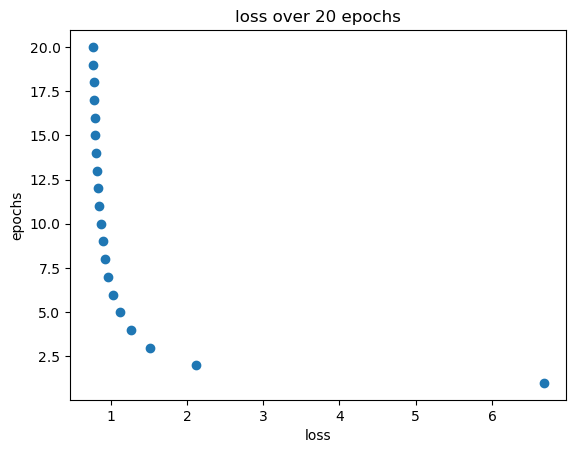

In [36]:
# plot the loss function over epoch
plt.scatter(x=loss_per_epoch, y=[x+1 for x in range(len(loss_per_epoch))])
plt.xlabel('loss')
plt.ylabel('epochs')
plt.title('loss over 20 epochs')

### generating prediction

In [37]:
# paramaeter for user 1
user_1_id = user_to_id[1]
anime_1_id = anime_to_id[1]

In [38]:
# bias
bu_1  = bu[user_1_id]
bi_1 = bi[anime_1_id]

# factor
pu_1 = pu[user_1_id]
qi_1 = qi[anime_1_id]

In [39]:
# prediction function
baseline_prediction = global_mean + bu_1 + bi_1

predicted_rating = baseline_prediction + pu_1.dot(qi_1.T)
print('predicted ratings on user 1 and item 1:', predicted_rating)

predicted ratings on user 1 and item 1: 9.570000421806881


In [40]:
rating_data.loc[(rating_data.user_id == 1) & (rating_data.anime_id == 1)]

,user_id,anime_id,rating


### object oriented code

In [41]:
class FunkSVD():
    def __init__(self, n_factors=50, n_epoch=20, lr=0.001, lambda_reg=0.002 ) -> None:
        '''
        initializes model hyperparameter/configuration

        parameters
        ----------
        n_factors : int
            number of latent factor to use
        n_epoch : int
            number of iterations during model training (epochs)
        lr : float
            learning rate
        lamba_reg : float
            regularization strength for objective function/model parameter

        returns
        -------
        -
        '''
        
        self.n_factors = n_factors
        self.n_epoch = n_epoch
        self.lr = lr
        self.lambda_reg = lambda_reg
        

    def generate_mapping(self):
        '''
        function to generate mapping on user_id and item_id
        '''
        
        user_unique = self.utility_matrix[self.user_column].unique()
        item_unique = self.utility_matrix[self.item_column].unique()

        self.user_to_id = {user_id: id for id, user_id in enumerate(user_unique)}
        self.id_to_user = {id: user_id for id, user_id in enumerate(user_unique)}
        
        self.item_to_id = {item_id: id for id, item_id in enumerate(item_unique)}
        self.id_to_item = {id: item_id for id, item_id in enumerate(item_unique)}


    def initialize_parameters(self):
        '''
        initializes biases and latent factor matrices

        parameters
        ----------
        n_users: int
            number of unique users
        n_items: int
            number of unique items
        n_factors: int
            number of factors

        returns
        -------
        bu : numpy.array
            user biases vector
        bi : numpy.array
            item biases vector
        pu : numpy.array
            user latent factors matrix
        qi : numpy.array
            item latent factors matrix
        '''
        bu = np.zeros(self.n_users)
        bi = np.zeros(self.n_items)

        pu = np.random.normal(0, .1, (self.n_users, self.n_factors))
        qi = np.random.normal(0, .1, (self.n_items, self.n_factors))

        return bu, bi, pu, qi


    def update_parameter(self, n_epoch, global_mean, bu, bi, pu, qi):
        '''
        function to update parameter with gradient descent
        
        parameters
        ----------
        n_epochs : int
            number of epochs
        global_mean : float
            global mean for computing baseline prediction
        bu : numpy.array
            user biases vector
        bi : numpy.array
            item biases vector
        pu : numpy.array
            user latent factors matrix
        qi : numpy.array
            item latent factors matrix

        returns
        -------
        bu : numpy.array
            updated user biases vector
        bi : numpy.array
            updated item biases vector
        pu : numpy.array
            updated user latent factors matrix
        qi : numpy.array
            updated item latent factors matrix
        loss_per_epoch : list
            zverage loss per epoch
        '''
        
        # copy parameter first to avoid overwriting
        bu = bu.copy()
        bi = bi.copy()
        pu = pu.copy()
        qi = qi.copy()

        # run update parameter
        loss_per_epoch = []
        
        for _ in range(n_epoch):
            # add empty list to add avg loss per epoch
            avg_loss_training_samples = []
            
            # iterate all over training data
            for training_samples in tqdm(self.utility_matrix):

                # extract user_id, anime_id, rating
                user = int(training_samples[0])
                item = int(training_samples[1])
                rating = training_samples[2]

                # get user id
                user_id = self.user_to_id[user]
                item_id = self.item_to_id[item]
                
                # predict rating

                # slice each parameter
                b_user = bu[user_id]
                b_item = bi[item_id]
                p_user = pu[user_id]
                q_item = qi[item_id]

                # calculate baseline prediction
                baseline_prediction = global_mean + b_user + b_item

                predicted_rating = baseline_prediction + p_user.dot(q_item.T)
                
                # calculate loss/objective
                loss = (
                    (rating - predicted_rating)**2 / 2
                    + (self.lambda_reg * (b_user + b_item + norm(p_user)**2 + norm(q_item)**2)) / 2
                )

                # append loss
                avg_loss_training_samples.append(loss)

                # calculate gradient, dy/d(parameter)
                grad_user_bias = (rating - predicted_rating) - (self.lambda_reg * b_user)
                grad_item_bias = (rating - predicted_rating) - (self.lambda_reg * b_item)
                grad_user_factor = (rating - predicted_rating) * q_item - (self.lambda_reg * p_user)
                grad_item_factor = (rating - predicted_rating) * p_user - (self.lambda_reg * q_item)

                # update parameter
                bu[user_id] += self.lr * grad_user_bias
                bi[item_id] += self.lr * grad_item_bias
                pu[user_id] += self.lr * grad_user_factor
                qi[item_id] += self.lr * grad_item_factor
                
            avg_loss_training_samples = np.mean(avg_loss_training_samples)
            loss_per_epoch.append(avg_loss_training_samples)

        return bu, bi, pu, qi, loss_per_epoch

    
    def fit(self, utility_matrix, user_column, item_column, utility_column):
        '''
        parameters
        ----------
            utility_matrix : dataframe
            user_column : str
            item_column : str
            utility_column : str

        returns
        -------
        self (object)
        '''

        self.utility_matrix = utility_matrix
        self.user_column = user_column
        self.item_column = item_column
        self.utility_column = utility_column

        # setting position of column
        self.utility_matrix = self.utility_matrix[[
            self.user_column,
            self.item_column,
            self.utility_column
        ]]
        
        # yield number of user
        self.n_users = self.utility_matrix[self.user_column].nunique()
        
        # yield number of items
        self.n_items = self.utility_matrix[self.item_column].nunique()

        # create id_mapping for user & item
        self.generate_mapping()

        # convert to numpy array
        self.utility_matrix = self.utility_matrix.to_numpy()

        # initialize parameters
        bu, bi, pu, qi = self.initialize_parameters()

        # extract global mean
        self.global_mean = self.utility_matrix[:,2].mean()

        # update parameters
        bu_updated, bi_updated, pu_updated, qi_updated,loss = self.update_parameter(
            n_epoch=self.n_epoch,
            global_mean=self.global_mean,
            bu=bu,
            bi=bi,
            pu=pu,
            qi=qi
        )

        # set updated parameter as part of object
        self.bu = bu_updated
        self.bi = bi_updated
        self.pu = pu_updated
        self.qi = qi_updated

        
    def predict_rating(self, user, item):
        '''
        parameters
        ----------
            user : int
            item : int

        returns
        -------
        predicted_rating : float
        '''

        # get user id
        user_id = self.user_to_id[user]
        item_id = self.item_to_id[item]
        
        # predict rating

        # slice each parameter
        b_user = self.bu[user_id]
        b_item = self.bi[item_id]
        p_user = self.pu[user_id]
        q_item = self.qi[item_id]

        # calculate baseline prediction
        baseline_prediction = self.global_mean + b_user + b_item

        predicted_rating = baseline_prediction + p_user.dot(q_item.T)

        return predicted_rating

In [42]:
model = FunkSVD()
model.fit(
    utility_matrix=rating_data,
    user_column='user_id',
    item_column='anime_id',
    utility_column='rating'
)

100%|██████████████████████████████| 6337234/6337234 [04:23<00:00, 24023.49it/s]


In [43]:
model.predict_rating(user=1, item=1)

8.856487399594888

## 3. predictions/generating recommendation

### predict all the unseen/unrated anime

In [45]:
# get unique anime_id
unique_anime_id = set(rating_data['anime_id'])
print(unique_anime_id)

{32768, 1, 5, 6, 7, 8, 32775, 32776, 32777, 32778, 32779, 32781, 15, 16, 17, 18, 19, 20, 32783, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 32801, 32802, 32800, 32803, 32804, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 32828, 61, 60, 63, 64, 65, 66, 67, 68, 62, 69, 71, 72, 73, 74, 75, 76, 77, 32844, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 32879, 113, 114, 115, 116, 112, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 32906, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 32935, 168, 167, 170, 169, 32934, 173, 174, 175, 176, 177, 178, 32947, 180, 181, 182, 183, 179, 185, 186, 187, 32954, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 32961, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

In [46]:
# get anime_id that is rated by user_id 1
rated_anime_id = set(rating_data.loc[rating_data['user_id']==1, 'anime_id'])
print(rated_anime_id)

{11617, 8074, 15451, 11757}


In [47]:
# find unrated anime_id
unrated_anime_id = unique_anime_id.difference(rated_anime_id)
print(unrated_anime_id)

{32768, 1, 5, 6, 7, 8, 32775, 32776, 32777, 32778, 32779, 32781, 15, 16, 17, 18, 19, 20, 32783, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 32801, 32802, 32800, 32803, 32804, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 32828, 61, 60, 63, 64, 65, 66, 67, 68, 62, 69, 71, 72, 73, 74, 75, 76, 77, 32844, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 32879, 113, 114, 115, 116, 112, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 32906, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 32935, 168, 167, 170, 169, 32934, 173, 174, 175, 176, 177, 178, 32947, 180, 181, 182, 183, 179, 185, 186, 187, 32954, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 32961, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

In [48]:
# create function
def get_unrated_item(user_id, rating_data):
    '''
    get unrated item id from a user id

    parameters
    ----------
    user_id : int
        user id

    rating_data : pandas dataframe
        rating data

    returns
    -------
    unrated_item_id : set
        unrated item id
    '''
    
    # find whole item_id
    unique_item_id = set(rating_data['anime_id'])

    # find item_id that was rated by user_id
    rated_item_id = set(rating_data.loc[rating_data['user_id']==user_id, 'anime_id'])

    # find unrated item_id
    unrated_item_id = unique_item_id.difference(rated_item_id)

    return unrated_item_id

In [49]:
unrated_anime_id = get_unrated_item(user_id=1, rating_data=rating_data)
print(unrated_anime_id)

{32768, 1, 5, 6, 7, 8, 32775, 32776, 32777, 32778, 32779, 32781, 15, 16, 17, 18, 19, 20, 32783, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 32801, 32802, 32800, 32803, 32804, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 32828, 61, 60, 63, 64, 65, 66, 67, 68, 62, 69, 71, 72, 73, 74, 75, 76, 77, 32844, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 32879, 113, 114, 115, 116, 112, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 32906, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 32935, 168, 167, 170, 169, 32934, 173, 174, 175, 176, 177, 178, 32947, 180, 181, 182, 183, 179, 185, 186, 187, 32954, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 32961, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

### create the prediction from the unrated anime

In [50]:
# initialize dict
predicted_unrated_anime = {
    'user_id': 1,
    'anime_id': [],
    'predicted_rating': []
}

predicted_unrated_anime

{'user_id': 1, 'anime_id': [], 'predicted_rating': []}

In [51]:
# loop for over all unrated anime_id
for anime_id in unrated_anime_id:
    # create a prediction
    pred = model.predict_rating(user=predicted_unrated_anime['user_id'], item=anime_id)

    # append
    predicted_unrated_anime['anime_id'].append(anime_id)
    predicted_unrated_anime['predicted_rating'].append(pred)

In [52]:
# convert to dataframe
predicted_unrated_anime = pd.DataFrame(predicted_unrated_anime)
predicted_unrated_anime

,user_id,anime_id,predicted_rating
0,1,32768,7.950414
1,1,1,8.856487
2,1,5,8.897103
3,1,6,8.945415
4,1,7,7.713000
...,...,...,...
9918,1,32761,8.003776
9919,1,32763,8.005534
9920,1,32764,7.864751
9921,1,32765,7.891195


In [53]:
# sort predicted rating values
predicted_unrated_anime = predicted_unrated_anime.sort_values('predicted_rating', ascending=False)
predicted_unrated_anime

,user_id,anime_id,predicted_rating
2746,1,2904,10.124659
5748,1,9253,9.961904
8908,1,28977,9.906237
784,1,820,9.873433
6022,1,9969,9.815658
...,...,...,...
7727,1,19315,4.789907
7316,1,16608,4.391496
6873,1,13405,4.050767
3041,1,3287,3.090924


In [54]:
# create unction
def get_pred_unrated_item(user_id, estimator, unrated_item_id):
    '''
    get predicted unrated item_id from user_id

    parameters
    ----------
    user_id : int
        user id

    estimator : svd model
        estimator

    unrated_item_id :  set
        unrated item id

    returns
    -------
    pred_data : pandas dataframe
        predicted rating of unrated item of user id
    '''
    
    # initialize dict
    prediction = {
        'user_id': user_id,
        'item_id': [],
        'predicted_rating': []
    }

    # loop for over all unrated anime_id
    for item_id in unrated_item_id:
        # create a prediction
        pred = estimator.predict_rating(user=prediction['user_id'], item=item_id)

        # append
        prediction['item_id'].append(item_id)
        prediction['predicted_rating'].append(pred)

    # create a dataframe
    prediction = pd.DataFrame(prediction).sort_values('predicted_rating', ascending=False)

    return prediction

In [55]:
predicted_unrated_anime = get_pred_unrated_item(
    user_id=1,
    estimator=model,
    unrated_item_id=unrated_anime_id
)

predicted_unrated_anime

,user_id,item_id,predicted_rating
2746,1,2904,10.124659
5748,1,9253,9.961904
8908,1,28977,9.906237
784,1,820,9.873433
6022,1,9969,9.815658
...,...,...,...
7727,1,19315,4.789907
7316,1,16608,4.391496
6873,1,13405,4.050767
3041,1,3287,3.090924


### create top movie predictions

In [56]:
def load_anime_data(anime_path):
    '''
    function to load anime data

    parameters
    ----------
    anime_path : str
        path of anime data (.csv)

    returns
    -------
    anime_data : pandas dataframe
        anime data
    '''
    
    # load data
    anime_data = pd.read_csv(anime_path)
    
    # set anime_id as index
    anime_data = anime_data.set_index('anime_id', drop=True)

    return anime_data

In [57]:
# load anime data
anime_data = load_anime_data(anime_path='data/anime.csv')
anime_data.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [58]:
# pick top k biggest rating
k = 5
top_anime = predicted_unrated_anime.head(k).copy()
top_anime

,user_id,item_id,predicted_rating
2746,1,2904,10.124659
5748,1,9253,9.961904
8908,1,28977,9.906237
784,1,820,9.873433
6022,1,9969,9.815658


In [59]:
# add the movie title
top_anime['title'] = anime_data.loc[top_anime['item_id'], 'name'].values
top_anime['genre'] = anime_data.loc[top_anime['item_id'], 'genre'].values

top_anime

,user_id,item_id,predicted_rating,title,genre
2746,1,2904,10.124659,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ..."
5748,1,9253,9.961904,Steins;Gate,"Sci-Fi, Thriller"
8908,1,28977,9.906237,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
784,1,820,9.873433,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space"
6022,1,9969,9.815658,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."


In [60]:
def get_top_highest_unrated(estimator, k, user_id, rating_data, anime_data):
    '''
    Get top k highest of unrated movie from a Surprise estimator RecSys

    parameters
    ----------
    estimator : svd model
        estimator

    k : int
        number of recommendations

    user_id : int
        user id to recommend

    rating_data : pandas dataframe
        rating data

    anime_data : pandas dataframe
        anime meta data

    returns
    -------
    top_item_pred : pandas dataframe
        top items recommendations
    '''
    
    # 1. det unrated item id of a user id
    unrated_item_id = get_unrated_item(user_id=user_id, rating_data=rating_data)

    # 2. create prediction from estimator to all unrated item id
    predicted_unrated_item = get_pred_unrated_item(
        user_id=user_id,
        estimator=estimator,
        unrated_item_id=unrated_item_id
    )

    # 3. sort & add meta data
    top_item_pred = predicted_unrated_item.head(k).copy()
    top_item_pred['title'] = anime_data.loc[top_item_pred['item_id'], 'name'].values
    top_item_pred['genre'] = anime_data.loc[top_item_pred['item_id'], 'genre'].values

    return top_item_pred

In [61]:
# generate 10 recommendation for user 100
get_top_highest_unrated(
    estimator=model,
    k=10,
    user_id=100,
    rating_data=rating_data,
    anime_data=anime_data
)

,user_id,item_id,predicted_rating,title,genre
784,100,820,9.973097,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space"
3651,100,4181,9.749053,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern..."
9794,100,32281,9.632037,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
8907,100,28977,9.576935,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
7122,100,15335,9.500614,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S..."
2064,100,2167,9.489635,Clannad,"Comedy, Drama, Romance, School, Slice of Life,..."
160,100,32935,9.467029,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports"
6686,100,12431,9.459448,Uchuu Kyoudai,"Comedy, Sci-Fi, Seinen, Slice of Life, Space"
5746,100,9253,9.422664,Steins;Gate,"Sci-Fi, Thriller"
1459,100,1530,9.358301,Kanon (2006),"Drama, Romance, Slice of Life, Supernatural"


In [62]:
# generate 10 recommendation for user 500
get_top_highest_unrated(
    estimator=model,
    k=10,
    user_id=500,
    rating_data=rating_data,
    anime_data=anime_data
)

,user_id,item_id,predicted_rating,title,genre
766,500,820,10.092987,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space"
8695,500,28977,9.810444,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
6316,500,11061,9.745228,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power"
5921,500,9969,9.731360,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
6959,500,15417,9.711074,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S..."
6950,500,15335,9.690939,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S..."
9582,500,32281,9.690401,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
859,500,918,9.645046,Gintama,"Action, Comedy, Historical, Parody, Samurai, S..."
9023,500,30276,9.630097,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ..."
4044,500,5114,9.592554,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
